# Behavioral Cloning

Imports

In [1]:
import numpy as np
import keras as k
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Input, Activation, Conv2D, Flatten, MaxPooling2D, Activation, Dropout
import pickle 
from PIL import Image
import os
import cv2
import math
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline  


Using TensorFlow backend.


Data visualization and analysis

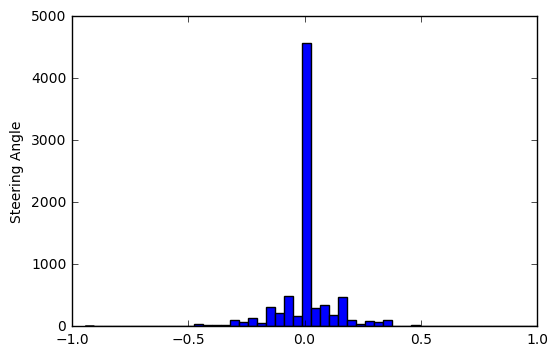

In [2]:
##Read driving_log.csv file and create X_data containing image names and y_data containing 
##their corresponding steering wheel angle
import csv
X_data = []
y_data = []
with open('data/driving_log.csv', 'rt') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    for i,row in enumerate(datareader):
        if i==0:
            continue
        X_data.append([row[0].strip(), row[1].strip(), row[2].strip()])
        y_data.append(float(row[3]))

X_data = np.array(X_data)
y_data = np.array(y_data)

#Plot histogram of steering wheel angles
plt.hist(y_data, 50)
plt.ylabel('Steering Angle')
plt.show()    
    

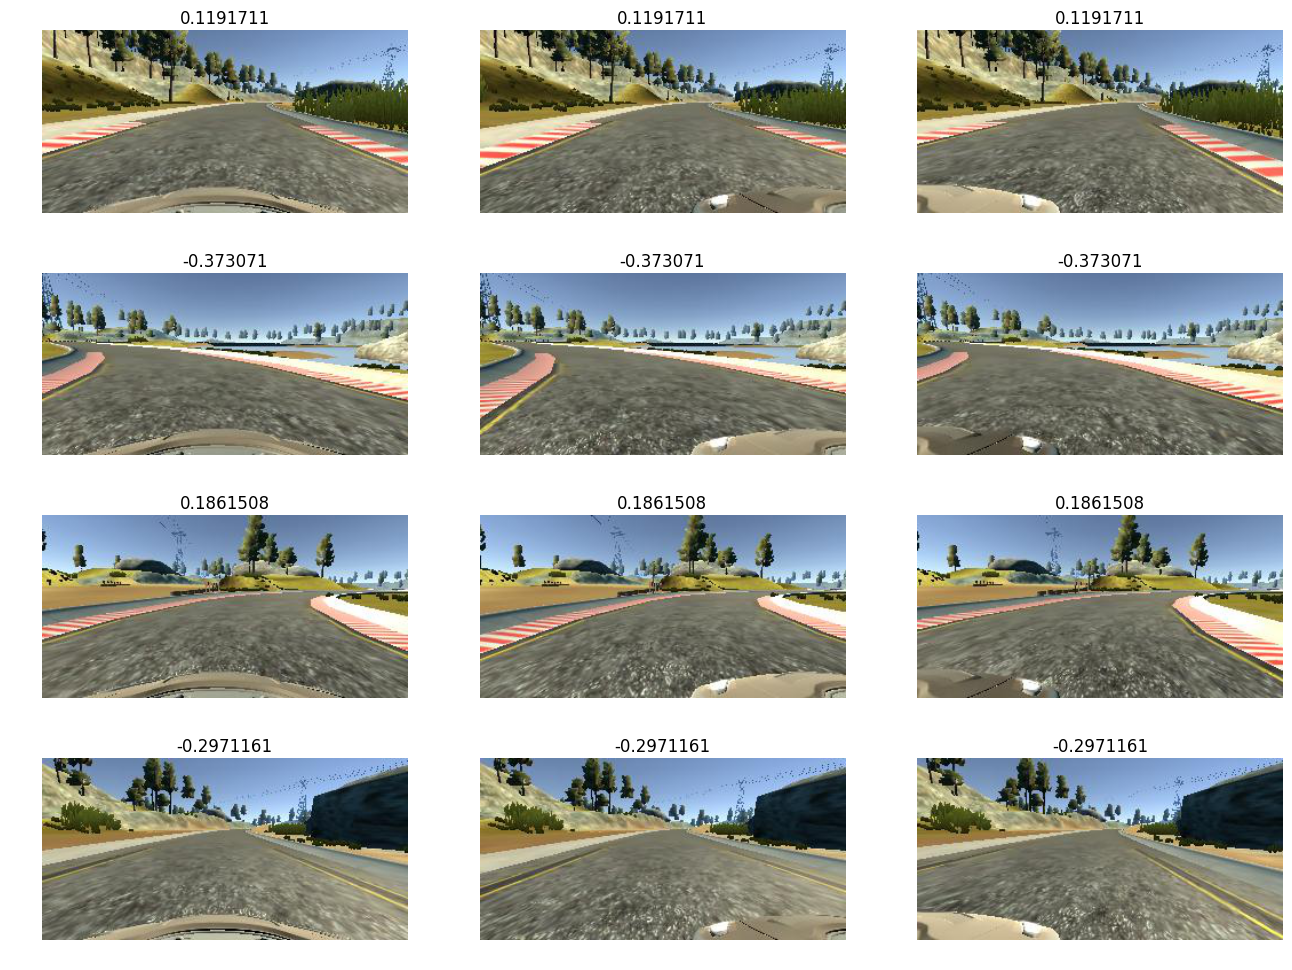

In [3]:
##Plotting sample images and their corresponding steering angles for visualization
labels, uniqueindices = np.unique(y_data, return_index=True)
fig = plt.figure(figsize=(16, 12))
x = 0
for i in range(4):
    ind = np.random.choice(uniqueindices)
    for j in range(3):
        x += 1
        img = Image.open(os.path.join('data', X_data[ind, j]))
        fig.add_subplot(4, 3, x)
        plt.imshow(img.copy())
        plt.axis('off')
        plt.title(str(y_data[ind]))
        img.close()

        
##Creating Data dictionary
##0.2 is added to steering angle of left camera images and 0.2 substracted from steering angle of right camera
##images
Data = {}
X_train = []
y_train = []
for i in range(len(y_data)):
    #Center Image
    img = Image.open(os.path.join('data', X_data[i, 0]))
    X_train.append(cv2.resize((array(img)[30:135, :, :]),(200,66)))
    y_train.append(y_data[i])
    img.close()
    #Left Image
    img = Image.open(os.path.join('data', X_data[i, 1]))
    X_train.append(cv2.resize((array(img)[30:135, :, :]),(200,66)))
    y_train.append(y_data[i] + 0.2)
    img.close()
    #Right Image
    img = Image.open(os.path.join('data', X_data[i, 2]))
    X_train.append(cv2.resize((array(img)[30:135, :, :]),(200,66)))
    y_train.append(y_data[i] - 0.2)
    img.close()
        

Data['X_train'] = np.array(X_train)
Data['y_train'] = np.array(y_train)

#Saving the data in train.p
pickle.dump(Data, open( "train.p", "wb" ) )
    


In [2]:
#Loading data from train.p
Data = None
X_data = None
y_data = None
X_train = None
y_train = None
Data = pickle.load(open( "train.p", "rb" ) )
X_train = Data['X_train']
y_train = Data['y_train']
print(X_train.shape)
print(y_train.shape)

(24108, 66, 200, 3)
(24108,)


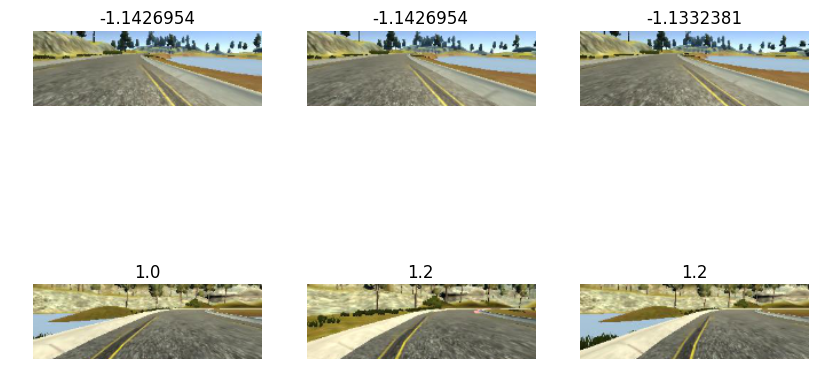

In [3]:
##Visualizing images with extreme steering angles
Data = None
extremeindices = np.argsort(y_train)
fig = plt.figure(figsize=(10, 6))
x = 0
for i in extremeindices[:3]:
    x += 1
    fig.add_subplot(2, 3, x)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(str(y_train[i]))
for i in extremeindices[-3:]:
    x += 1
    fig.add_subplot(2, 3, x)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(str(y_train[i]))






Data Augmentation

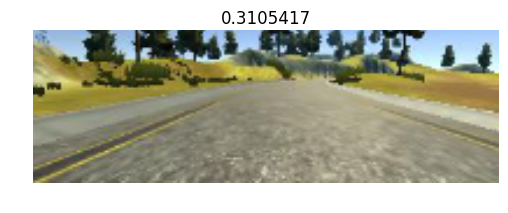

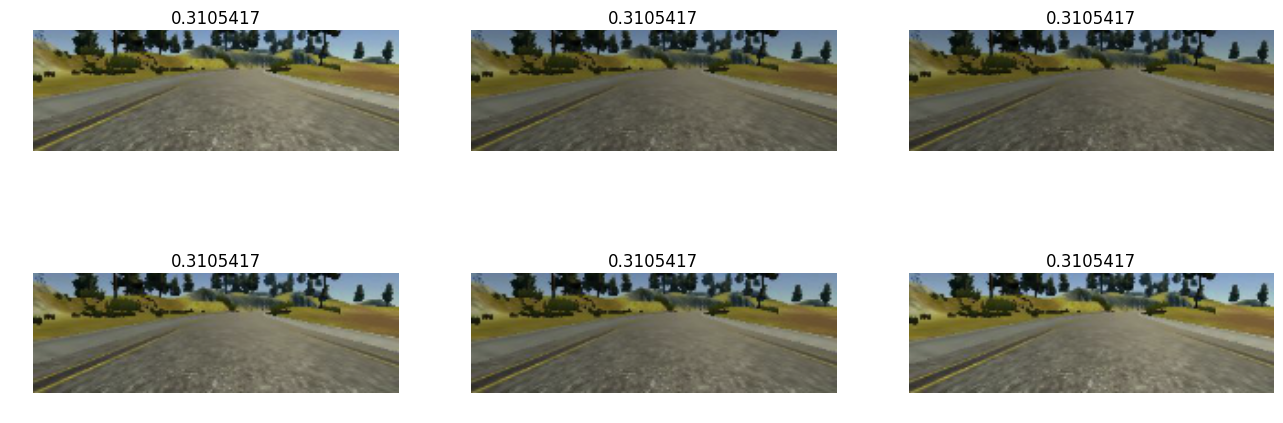

In [4]:
##Changing brightness of the image
def brightness(img, strAng):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    deltaBright = .5 + np.random.uniform() * 0.5
    hsv[:, :, 2] = np.around(hsv[:, :, 2] * deltaBright)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img, strAng

labels, uniqueindices = np.unique(y_train, return_index=True)
ind = np.random.choice(uniqueindices)
fig = plt.figure()
plt.imshow(X_train[ind])
plt.axis('off')
plt.title(str(y_train[ind]))

fig = plt.figure(figsize=(16, 12))
x = 0
for i in range(2):
    for j in range(3):
        x += 1
        img, strAng = brightness(X_train[ind], y_train[ind])
        fig.add_subplot(4, 3, x)
        plt.imshow(img)
        plt.axis('off')
        plt.title(str(strAng))

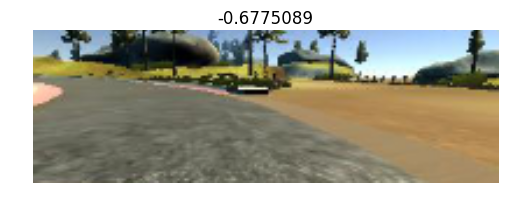

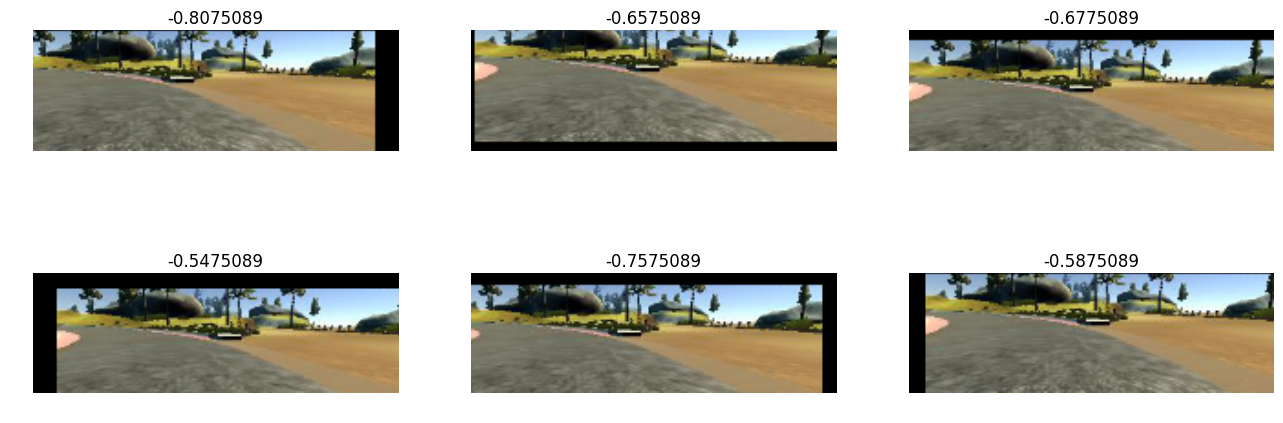

In [5]:
##Horizantal and Vertical Shifts
def shift(img, strAng):
    vertShift =  np.around(np.random.randn() * 66 * 0.075)
    horShift =  np.around(np.random.randn() * 200 * 0.075)
    M = np.float32([[1,0,horShift],[0,1,vertShift]])
    rows, cols, _ = img.shape
    img = cv2.warpAffine(img,M,(cols,rows))
    strAng += horShift * 0.01
    return img, strAng

labels, uniqueindices = np.unique(y_train, return_index=True)
ind = np.random.choice(uniqueindices)
fig = plt.figure()
plt.imshow(X_train[ind])
plt.axis('off')
plt.title(str(y_train[ind]))

fig = plt.figure(figsize=(16, 12))
x = 0
for i in range(2):
    for j in range(3):
        x += 1
        img, strAng = shift(X_train[ind], y_train[ind])
        fig.add_subplot(4, 3, x)
        plt.imshow(img)
        plt.axis('off')
        plt.title(str(strAng))
    

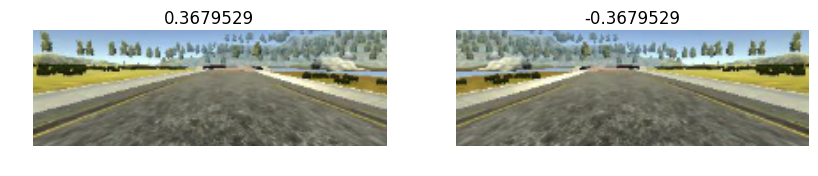

In [6]:
## flipping the image
def flip(img, strAng):
    img = img[:,::-1,:]
    strAng = -1 * strAng
    return img, strAng

labels, uniqueindices = np.unique(y_train, return_index=True)
ind = np.random.choice(uniqueindices)
fig = plt.figure(figsize = (10,10))
fig.add_subplot(1, 2, 1)
plt.imshow(X_train[ind])
plt.axis('off')
plt.title(str(y_train[ind]))
fig.add_subplot(1, 2, 2)
img, strAng = flip(X_train[ind], y_train[ind])
plt.imshow(img)
plt.axis('off')
plt.title(str(strAng))

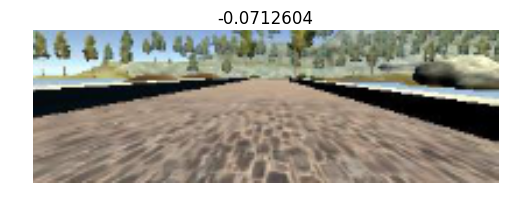

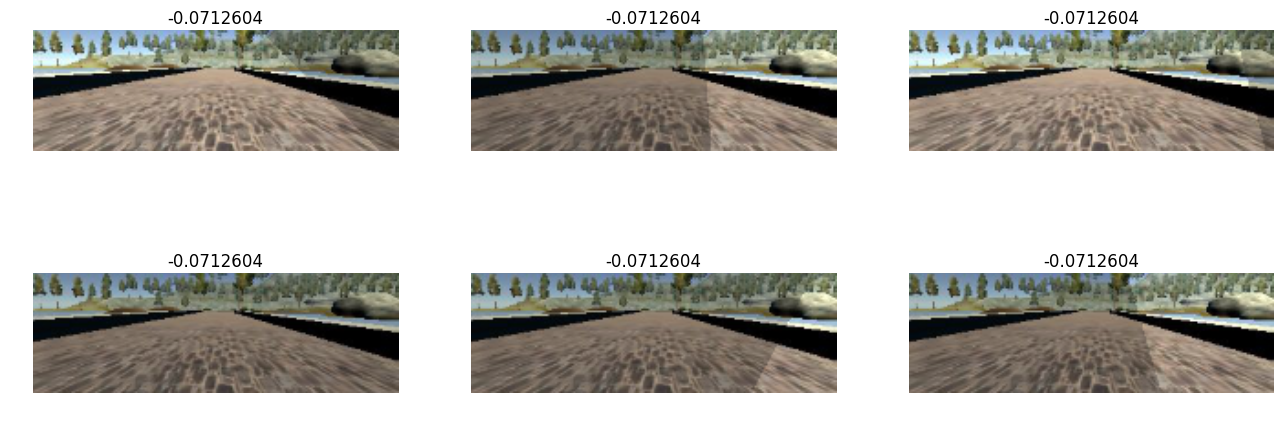

In [7]:
##Add shadows at random angles
def shadow(img, strAng):
    y1 = 0
    y2 = 104
    x1 = np.random.choice(range(100, 230))
    x2 = np.random.choice(range(100, 230))
    m = (y2 - y1) / (x2 - x1)
    c = y2 - m * x2

    img = X_train[ind]
    rightshade = np.random.uniform() > 0.5
    mask = np.ones((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if rightshade:
                if j>((i - c)/m):
                    mask[i, j] = 0.75
            else:
                if j<((i - c)/m):
                    mask[i, j] = 0.75

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = np.around(hsv[:, :, 2] * mask)
    shdimg = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return shdimg, strAng

labels, uniqueindices = np.unique(y_train, return_index=True)
ind = np.random.choice(uniqueindices)
fig = plt.figure()
plt.imshow(X_train[ind])
plt.axis('off')
plt.title(str(y_train[ind]))

fig = plt.figure(figsize=(16, 12))
x = 0
for i in range(2):
    for j in range(3):
        x += 1
        img, strAng = shadow(X_train[ind], y_train[ind])
        fig.add_subplot(4, 3, x)
        plt.imshow(img)
        plt.axis('off')
        plt.title(str(strAng))
    

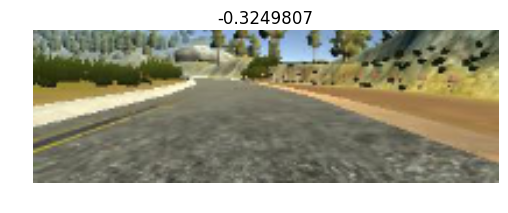

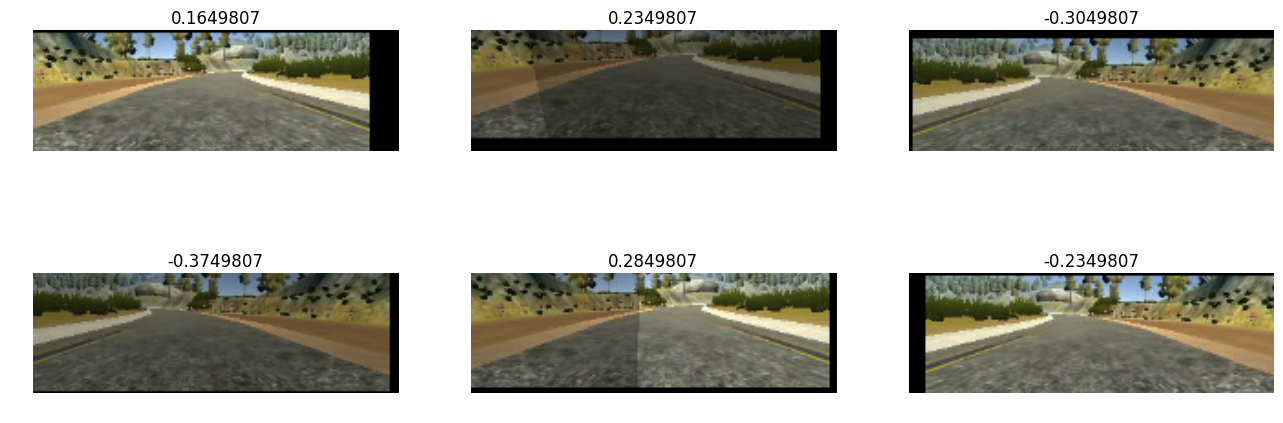

In [8]:
##Image augmentation combining shadow, flip, shift, brightness
def augment(img, strAng):
    if np.random.uniform()>0.5:
        img, strAng = shadow(img, strAng)
    if np.random.uniform()>0.5:
        img, strAng = flip(img, strAng)
    img, strAng = shift(img, strAng)
    if np.random.uniform()>0.5:
        img, strAng = brightness(img, strAng)
    return img, strAng

labels, uniqueindices = np.unique(y_train, return_index=True)
ind = np.random.choice(uniqueindices)
fig = plt.figure()
plt.imshow(X_train[ind])
plt.axis('off')
plt.title(str(y_train[ind]))

fig = plt.figure(figsize=(16, 12))
x = 0
for i in range(2):
    for j in range(3):
        x += 1
        img, strAng = augment(X_train[ind], y_train[ind])
        fig.add_subplot(4, 3, x)
        plt.imshow(img)
        plt.axis('off')
        plt.title(str(strAng))


In [9]:
from sklearn.utils import shuffle
##Generator
def generate_batch(X_train, y_train, batch_size = 128):
    while 1:
        X_train_batch = []
        y_train_batch = []
        for x in range(64):
            ind = np.random.randint(len(y_train))
            X_train_batch.append(X_train[ind])
            y_train_batch.append(y_train[ind])
            img, strAng = augment(X_train[ind], y_train[ind])
            X_train_batch.append(img)
            y_train_batch.append(strAng)
            #Normalize
        X_train_batch_np = np.array(X_train_batch)
        y_train_batch_np = np.array(y_train_batch)
        X_train_batch_np = (X_train_batch_np / 255) - 0.5
            
        X_train_batch_np, y_train_batch_np = shuffle(X_train_batch_np, y_train_batch_np)
            
        yield (X_train_batch_np, y_train_batch_np)

In [14]:
##Create validation data
def ValidationData():
    X_val_batch = []
    y_val_batch = []
    for x in range(3000):
        ind = np.random.randint(len(y_train))
        X_val_batch.append(X_train[ind])
        y_val_batch.append(y_train[ind])
        img, strAng = augment(X_train[ind], y_train[ind])
        X_val_batch.append(img)
        y_val_batch.append(strAng)
        
    #Normalize
    X_val_batch_np = np.array(X_val_batch)
    y_val_batch_np = np.array(y_val_batch)
    X_val_batch_np = (X_val_batch_np / 255) - 0.5
            
    X_val_batch_np, y_val_batch_np = shuffle(X_val_batch_np, y_val_batch_np)
    return X_val_batch_np, y_val_batch_np

X_val, y_val = ValidationData()

/home/jeshwanth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in long_scalars
/home/jeshwanth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars
/home/jeshwanth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [15]:
#Nvidia Model as mentioned in the paper

def Nvidia_model():
    model = Sequential()

    #ConvLayer1
    model.add(Conv2D(24, 5, 5, input_shape=(66, 200, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    #ConvLayer2
    model.add(Conv2D(36, 5, 5))
    model.add(MaxPooling2D((2,2)))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    #ConvLayer3
    model.add(Conv2D(48, 5, 5))
    model.add(MaxPooling2D((2,2), border_mode='same'))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    #ConvLayer4
    model.add(Conv2D(64, 3, 3))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    #ConvLayer5
    model.add(Conv2D(64, 3, 3))
    model.add((Dropout(0.5)))
    model.add(Activation('relu'))

    #Flatten
    model.add(Flatten())

    #FullyConnected1
    model.add(Dense(1164, activation='relu'))
    model.add((Dropout(0.5)))

    #FullyConnected2
    model.add(Dense(100, activation='relu'))

    #FullyConnected3
    model.add(Dense(50, activation='relu'))

    #FullyConnected4
    model.add(Dense(10, activation='relu'))

    #FullyConnected5
    model.add(Dense(1))
    
    return model

model = Nvidia_model()

for l in model.layers:
    print(l.input_shape, l.output_shape)


(None, 66, 200, 3) (None, 62, 196, 24)
(None, 62, 196, 24) (None, 31, 98, 24)
(None, 31, 98, 24) (None, 31, 98, 24)
(None, 31, 98, 24) (None, 31, 98, 24)
(None, 31, 98, 24) (None, 27, 94, 36)
(None, 27, 94, 36) (None, 13, 47, 36)
(None, 13, 47, 36) (None, 13, 47, 36)
(None, 13, 47, 36) (None, 13, 47, 36)
(None, 13, 47, 36) (None, 9, 43, 48)
(None, 9, 43, 48) (None, 5, 22, 48)
(None, 5, 22, 48) (None, 5, 22, 48)
(None, 5, 22, 48) (None, 5, 22, 48)
(None, 5, 22, 48) (None, 3, 20, 64)
(None, 3, 20, 64) (None, 3, 20, 64)
(None, 3, 20, 64) (None, 3, 20, 64)
(None, 3, 20, 64) (None, 1, 18, 64)
(None, 1, 18, 64) (None, 1, 18, 64)
(None, 1, 18, 64) (None, 1, 18, 64)
(None, 1, 18, 64) (None, 1152)
(None, 1152) (None, 1164)
(None, 1164) (None, 1164)
(None, 1164) (None, 100)
(None, 100) (None, 50)
(None, 50) (None, 10)
(None, 10) (None, 1)


In [18]:
##Training model
model = Nvidia_model()

# model.summary()
# TODO: Compile and train the model here.
model.compile(loss='mean_squared_error', optimizer='adam')

generator = generate_batch(X_train, y_train)
model.fit_generator(generator, samples_per_epoch = len(y_train), validation_data = (X_val, y_val),
                              nb_epoch = 10, verbose=2)

Epoch 1/10


/home/jeshwanth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in long_scalars
/home/jeshwanth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in double_scalars
/home/jeshwanth/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars
/home/jeshwanth/anaconda3/envs/py35/lib/python3.5/site-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


475s - loss: 0.0314 - val_loss: 0.0281
Epoch 2/10
478s - loss: 0.0267 - val_loss: 0.0268
Epoch 3/10
476s - loss: 0.0267 - val_loss: 0.0253
Epoch 4/10
469s - loss: 0.0268 - val_loss: 0.0248
Epoch 5/10
474s - loss: 0.0255 - val_loss: 0.0244
Epoch 6/10
472s - loss: 0.0246 - val_loss: 0.0256
Epoch 7/10
472s - loss: 0.0250 - val_loss: 0.0246
Epoch 8/10
473s - loss: 0.0254 - val_loss: 0.0244
Epoch 9/10
479s - loss: 0.0248 - val_loss: 0.0240
Epoch 10/10
460s - loss: 0.0251 - val_loss: 0.0230


In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [20]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


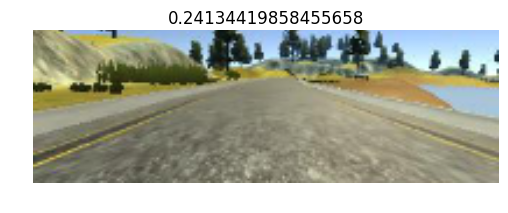

In [21]:
labels, uniqueindices = np.unique(y_train, return_index=True)
ind = np.random.choice(uniqueindices)

fig = plt.figure()
img = X_train[ind]
plt.imshow(img)
plt.axis('off')
img = img[None, :, :, :]
strAng = float(model.predict(img, batch_size=1))
plt.title(str(strAng))
